In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from vae import Flatten, UnFlatten, VAE

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [7]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import torch

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
'''train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)'''

'train_ds = ImageFolder(DATA_DIR, transform=T.Compose([\n    T.Resize(image_size),\n    T.CenterCrop(image_size),\n    T.ToTensor(),\n    T.Normalize(*stats)]))\n\ntrain_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)'

In [11]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize((64,64)),
    T.ToTensor()]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
#print(type(train_dl))
#print(len(train_ds))
#animefacedataset = torch.empty(size=(len(train_ds), 3, 64, 64))
animefacedataset = torch.empty(size=(60000, 3, 64, 64))
print(animefacedataset.shape)
for i in range(len(train_ds)):
    if i == 60000:
      break
    animefacedataset[i] = train_ds[i][0]


torch.save(animefacedataset,'/content/animefacedata.pt')

torch.Size([60000, 3, 64, 64])


In [10]:
#batch_size = 100
#animefacedataset_1 = torch.empty(size=(len(train_dl), batch_size, 3, 64, 64))
#for i in range(len(train_dl)):
 # animefacedataset_1[i] = train_dl[i][0]

#print(animefacedataset_1.shape)
#print(len(train_dl))

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [18]:
image_channels = 3
epochs = 25

print('image_channels', image_channels)

model = VAE(image_channels=image_channels).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

image_channels 3


In [19]:
batch_size_cfs = 25
image_batches_trn = torch.load('/content/animefacedata.pt').to(device)




In [20]:
image_batches_trn = image_batches_trn.reshape(int(image_batches_trn.shape[0]/batch_size_cfs), batch_size_cfs, 3, 64,64)
print('image_batches_trn.shape', image_batches_trn.shape)

image_batches_trn.shape torch.Size([2400, 25, 3, 64, 64])


In [21]:
for images in image_batches_trn:
  print(images.shape)
  break

torch.Size([25, 3, 64, 64])


In [17]:
for epoch in range(100):
    #for idx, (images, _) in enumerate(train_loader):
    inum = 0
    for images in image_batches_trn:
        #print(inum)    
        inum = inum+1
        #images = torch.cuda.FloatTensor(images)
        #print('images.shape', images.shape)
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images.to(device), images.to(device), mu.to(device), logvar.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                #epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)
    print('loss', loss)
    print("Epoch : ", epoch)

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/animefacedataVAE.torch')

In [30]:
from google.colab import files
files.download('animefacedataVAE.torch')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
!python vae_cnn_train_animes.py

Traceback (most recent call last):
  File "vae_cnn_train_animes.py", line 51, in <module>
    images_check, labels_check = testiter.next()
AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'


In [12]:
image_channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [26]:
model_load = VAE(image_channels=image_channels).to(device)
model_load.load_state_dict(torch.load('/content/animefacedataVAE.torch', map_location=torch.device('cuda')))

<All keys matched successfully>

In [32]:
for images in train_dl:
  
  #print(images.shape)
  recon_images, mu, logvar =model_load(images)
  images=images
  break


TypeError: ignored

In [ ]:
for images in image_batches_trn:
  
  print(images.shape)
  recon_images, mu, logvar =model_load(images)
  images=images
  break


torch.Size([25, 3, 64, 64])


In [37]:
print(recon_images.shape)

torch.Size([25, 3, 64, 64])


In [23]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [24]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

TypeError: ignored

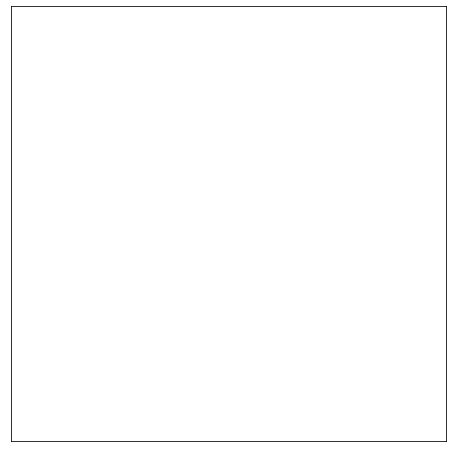

In [30]:
show_images(images[1])
show_images(recon_images[1], nmax=64)

torch.Size([1, 256])


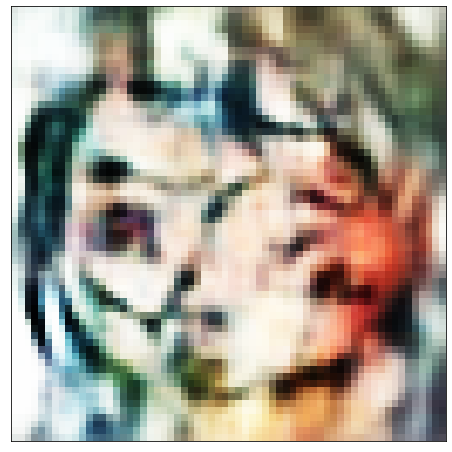

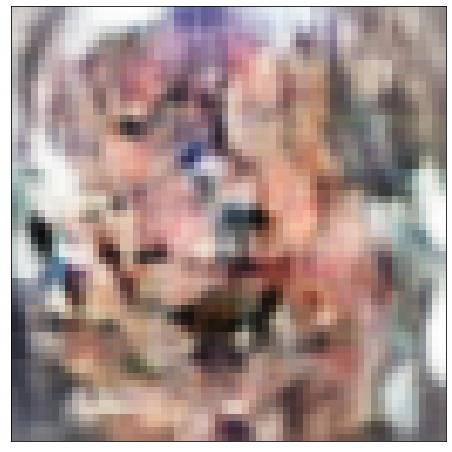

In [73]:
z_dim = 256
h_dim = 1024
batch_size=1
z = torch.randn(batch_size, z_dim, device=device)
h = torch.randn(batch_size, h_dim, device=device)
print(z.shape)
generated_image1=model_load.decoder(model_load.fc3(z))
generated_image2=model_load.decoder(h)
show_images(generated_image1)
show_images(generated_image2)

tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

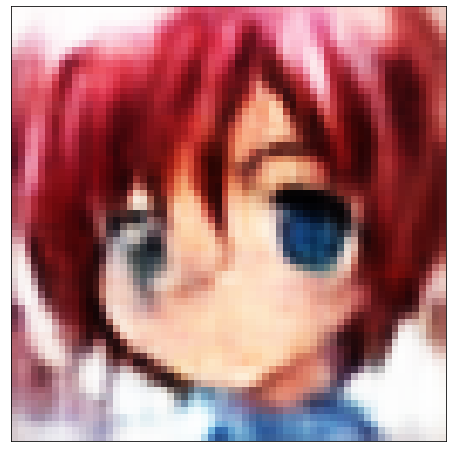

In [108]:
h=model_load.encoder(images[1:2])
z, mu, logvar = model_load.bottleneck(h)
add=torch.zeros(size=(z.shape))
add[:,1]=10
z=z+add
print(add)
generated_image1=model_load.decoder(model_load.fc3(z))
show_images(generated_image1)

In [ ]:
psnr, ssim

In [ ]:
std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
esp = torch.randn(*mu.size()).to(device)
z = mu + std * esp